In [10]:
from glob import glob
import re
import mne_bids
import numpy as np
import pandas as pd
from collections import defaultdict
from mne.parallel import parallel_func

import mvEEG
import matplotlib.pyplot as plt
import tqdm as tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
DATA_DIR = r"E:\datasets\supracapacity\derivatives"

EXPERIMENT_NAME='supracapacity'

dropped_chans={
    'eeg':['Fp1','Fp2'],
    'eog':'ALL',
    'eyegaze':'ALL',
    'pupil':'ALL',
    'misc':'ALL'
}

conditions = ['memory/ss2/no_placeholders','memory/ss2/placeholders',
                'memory/ss4/no_placeholders','memory/ss4/placeholders',
                'memory/ss6/no_placeholders','memory/ss6/placeholders',
                'memory/ss8/no_placeholders','memory/ss8/placeholders',
                'attention/ss2/no_placeholders','attention/ss2/placeholders',
                'attention/ss4/no_placeholders','attention/ss4/placeholders',
                'attention/ss6/no_placeholders','attention/ss6/placeholders',
                'attention/ss8/no_placeholders','attention/ss8/placeholders']

cr = mvEEG.Crossnobis()
wrangl = mvEEG.Wrangler(data_dir=DATA_DIR,experiment_name=EXPERIMENT_NAME,dropped_chans=dropped_chans,conditions=conditions,n_folds=1000,dropped_subs=['20'])
RUN_DESCRIPTION="RSA"


In [96]:

for isub in tqdm.tqdm(range(wrangl.nsub)):
    
    Xdata,ydata = wrangl.load_eeg(isub,reject=False)



    sub_path = mne_bids.BIDSPath(root=DATA_DIR,task=EXPERIMENT_NAME,subject=wrangl.subs[isub],datatype='rdms',description=RUN_DESCRIPTION,extension='.npy',check=False)
    sub_path.mkdir()

    parallel,p_func,_ = parallel_func(cr.crossnobis_across_time,n_jobs = -1)

    out = parallel(
        p_func(
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
        )
        for X_train,X_test,y_train,y_test in wrangl.bin_and_split(Xdata,ydata,test_size=0.5)
    )
    rdm = np.stack(out)

    sub_path.update(suffix='RDM')
    np.save(sub_path.fpath,rdm)
    sub_path.update(suffix='times')
    np.save(sub_path.fpath,wrangl.t)




 17%|█▋        | 5/30 [02:51<14:19, 34.38s/it]


ValueError: Channel(s) HEOG, VEOG, StimTrak not found, nothing dropped.

In [182]:
condition_details = {
    'M2N':{"n_items":2,"n_relevant":2,"task":0,"wmload":2,"placeholders":0},
    'M4N':{"n_items":4,"n_relevant":4,"task":0,"wmload":4,"placeholders":0},
    'M6N':{"n_items":6,"n_relevant":6,"task":0,"wmload":6,"placeholders":0},
    'M8N':{"n_items":8,"n_relevant":8,"task":0,"wmload":8,"placeholders":0},
    'M2P':{"n_items":10,"n_relevant":2,"task":0,"wmload":2,"placeholders":1},
    'M4P':{"n_items":10,"n_relevant":4,"task":0,"wmload":4,"placeholders":1},
    'M6P':{"n_items":10,"n_relevant":6,"task":0,"wmload":6,"placeholders":1},
    'M8P':{"n_items":10,"n_relevant":8,"task":0,"wmload":8,"placeholders":1},
    'A2N':{"n_items":2,"n_relevant":2,"task":1,"wmload":0,"placeholders":0},
    'A4N':{"n_items":4,"n_relevant":4,"task":1,"wmload":0,"placeholders":0},
    'A6N':{"n_items":6,"n_relevant":6,"task":1,"wmload":0,"placeholders":0},
    'A8N':{"n_items":8,"n_relevant":8,"task":1,"wmload":0,"placeholders":0},
    'A2P':{"n_items":10,"n_relevant":2,"task":1,"wmload":0,"placeholders":1},
    'A4P':{"n_items":10,"n_relevant":4,"task":1,"wmload":0,"placeholders":1},
    'A6P':{"n_items":10,"n_relevant":6,"task":1,"wmload":0,"placeholders":1},
    'A8P':{"n_items":10,"n_relevant":8,"task":1,"wmload":0,"placeholders":1},
}

rsa = mvEEG.RSA(root_dir=DATA_DIR,experiment_name=EXPERIMENT_NAME,condition_details=condition_details,subs=['01','03','04'])

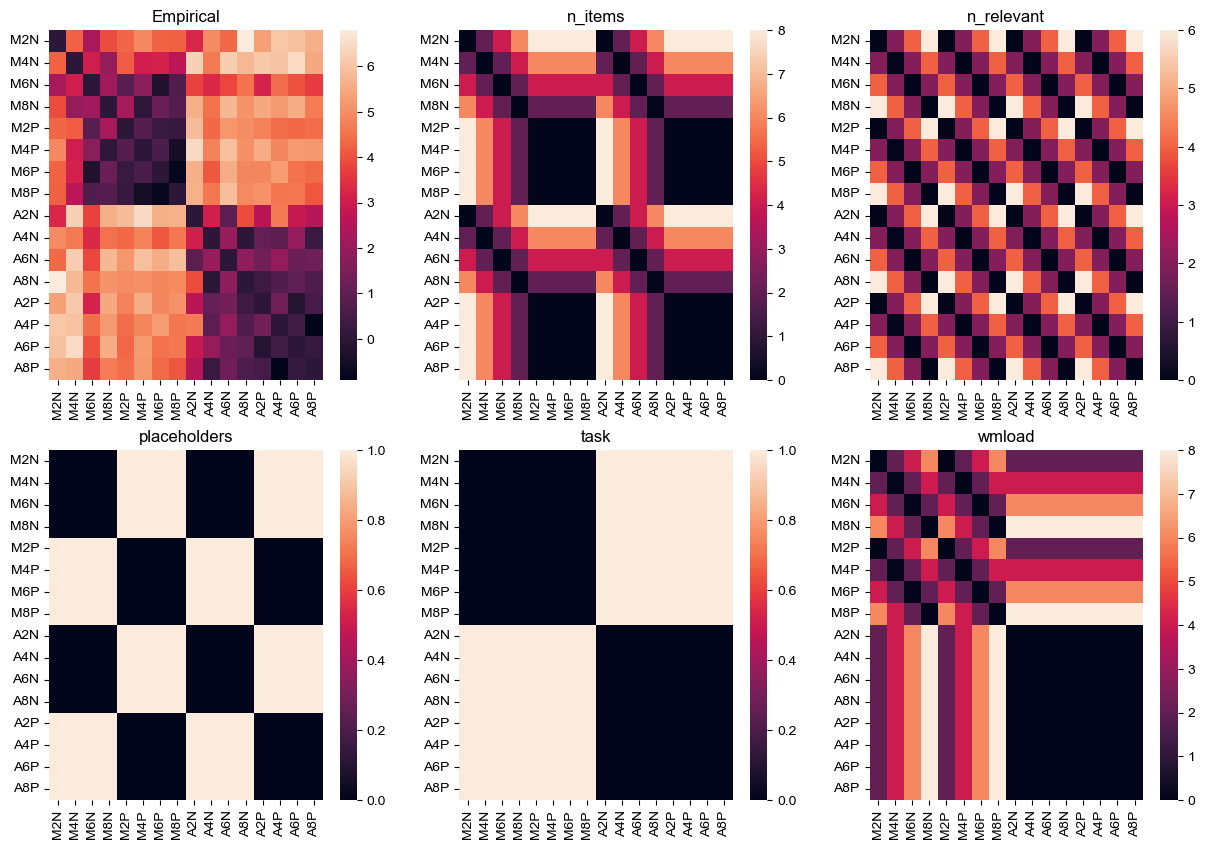

In [197]:
fig,ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()
for i,model in enumerate(['Empirical'] + list(rsa.theoretical_models.keys())):
    rsa.visualize_rdm(model,ax=ax[i],title=model)


In [183]:
rsa.fit_theoretical_models()

n_items 0.20803090629511964 6.0 0.125
n_relevant -0.03201340556600573 0.0 1.0
placeholders -0.07505375755668564 0.0 1.0
task 0.3452785469894802 6.0 0.125
wmload 0.05605642352198434 5.0 0.25


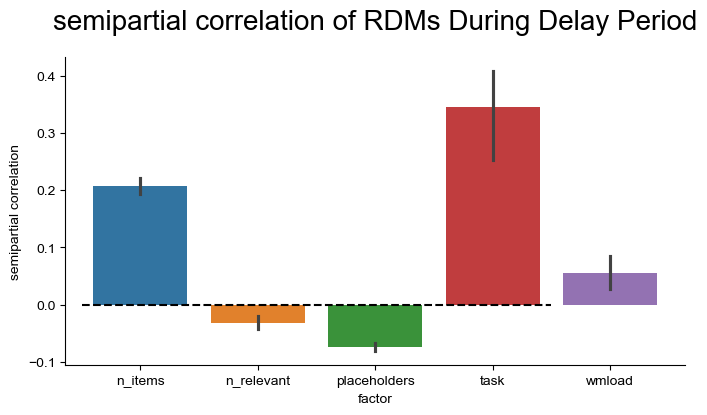

In [188]:
rsa.plot_corrs()

<Axes: title={'center': 'Model Fits across time'}, xlabel='timepoint', ylabel='semipartial correlation'>

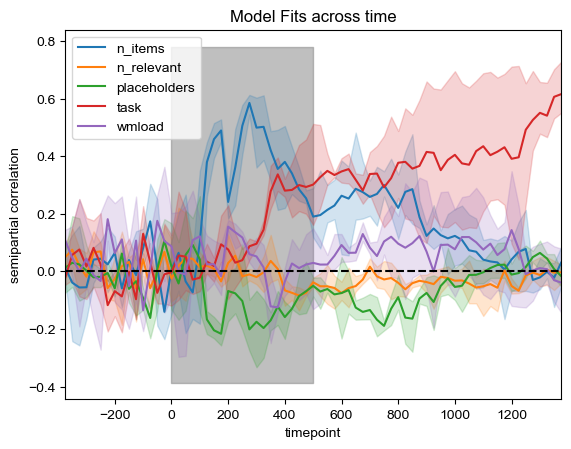

In [190]:
rsa.plot_corrs_temporal()